# Context Assignment

build mood detection model based on CNN

compare EfficientNet b0 transfer learning model and custom CNN model

data source : [kaggle](https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset)

note : using only 5 classes out of 7 available classes on dataset because the data of 2 unused classes is not enough so that it reduces the accuracy of the model

# Import Library

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow import keras
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from keras.models import save_model
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

retrieve data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

unpack the data from zip file

In [ ]:
path = '/content/drive/MyDrive/emotion/images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

load the data and generate

In [ ]:
picture_size = (48, 48)
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode='reflect')

train_dataset = training_generator.flow_from_directory('/content/images/train',
                                                        target_size = picture_size,
                                                        batch_size = 100,
                                                        class_mode = 'categorical',
                                                        color_mode = 'grayscale',
                                                        shuffle = True)

test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/images/validation',
                                                  target_size = picture_size,
                                                  batch_size = 100,
                                                  class_mode = 'categorical',
                                                  color_mode = 'grayscale',
                                                  shuffle = False)



Found 25180 images belonging to 5 classes.
Found 6158 images belonging to 5 classes.


# Exploratory Data Analysis

visualize data sample from 'happy' class

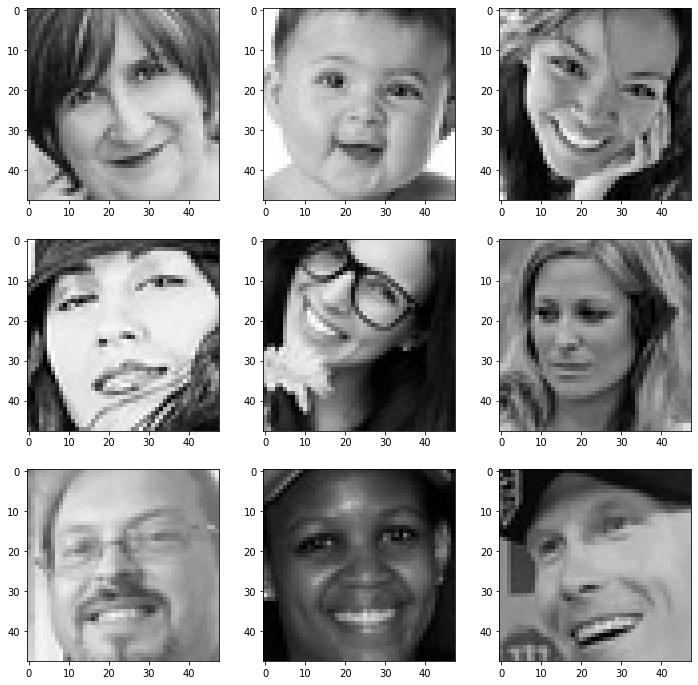

In [ ]:
expression = 'happy'
folder_path = '/content/images/'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=picture_size)
    plt.imshow(img)   
plt.show()

number of data in every class

In [ ]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([3993, 4103, 7164, 4982, 4938]))

compare data between classes

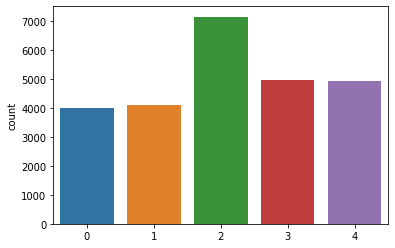

In [ ]:
sns.countplot(x = train_dataset.classes);

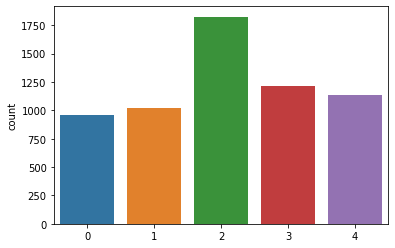

In [ ]:
sns.countplot(x = test_dataset.classes);

each classes represent mood

In [ ]:
train_dataset.class_indices

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}

# Build Custom Baseline Model

pack all callbacks into a single variable in this case i use early stoping and ReduceLROnPlateau

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
callbacks_list = [early_stopping,reduce_learningrate]

In [ ]:
tf.keras.backend.clear_session()

num_detectors = 32
num_classes = 5
epochs = 70

model01 = Sequential()

model01.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (48, 48, 1)))
model01.add(BatchNormalization())
model01.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
model01.add(BatchNormalization())
model01.add(MaxPooling2D(pool_size=(2,2)))
model01.add(Dropout(0.2))

model01.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
model01.add(BatchNormalization())
model01.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
model01.add(BatchNormalization())
model01.add(MaxPooling2D(pool_size=(2,2)))
model01.add(Dropout(0.2))

model01.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
model01.add(BatchNormalization())
model01.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
model01.add(BatchNormalization())
model01.add(MaxPooling2D(pool_size=(2,2)))
model01.add(Dropout(0.2))

model01.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
model01.add(BatchNormalization())
model01.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
model01.add(BatchNormalization())
model01.add(MaxPooling2D(pool_size=(2,2)))
model01.add(Dropout(0.2))

model01.add(Flatten())

model01.add(Dense(2 * num_detectors, activation='relu'))
model01.add(BatchNormalization())
model01.add(Dropout(0.2))

model01.add(Dense(2 * num_detectors, activation='relu'))
model01.add(BatchNormalization())
model01.add(Dropout(0.2))

model01.add(Dense(num_classes, activation='softmax'))

model01.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history01 = model01.fit(train_dataset, epochs=epochs,validation_data=test_dataset,callbacks=callbacks_list)

Epoch 1/70
252/252 [==============================] - 45s 124ms/step - loss: 1.7297 - accuracy: 0.2745 - val_loss: 1.6721 - val_accuracy: 0.2964 - lr: 0.0010
Epoch 2/70
252/252 [==============================] - 29s 115ms/step - loss: 1.5106 - accuracy: 0.3621 - val_loss: 1.4093 - val_accuracy: 0.4151 - lr: 0.0010
Epoch 3/70
252/252 [==============================] - 29s 116ms/step - loss: 1.3619 - accuracy: 0.4350 - val_loss: 1.4018 - val_accuracy: 0.4492 - lr: 0.0010
Epoch 4/70
252/252 [==============================] - 29s 115ms/step - loss: 1.2439 - accuracy: 0.4925 - val_loss: 1.1373 - val_accuracy: 0.5373 - lr: 0.0010
Epoch 5/70
252/252 [==============================] - 29s 116ms/step - loss: 1.1649 - accuracy: 0.5295 - val_loss: 1.1451 - val_accuracy: 0.5425 - lr: 0.0010
Epoch 6/70
252/252 [==============================] - 29s 115ms/step - loss: 1.1186 - accuracy: 0.5486 - val_loss: 1.0582 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 7/70
252/252 [==============================] 

model summary

In [ ]:
print(model01.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

build function for visualize lose graph

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Visualize lose and accuracy Baseline model 

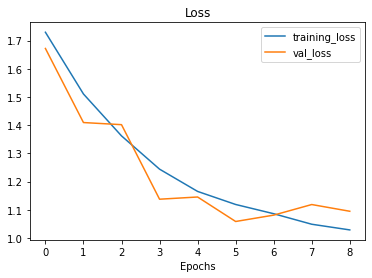

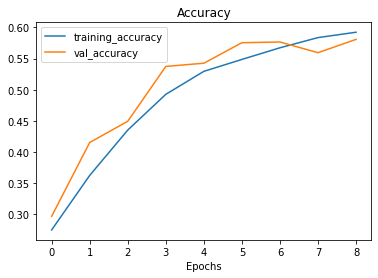

In [ ]:
plot_loss_curves(history01)

# Build EfficientNet B0 Transfer Learning 

In [ ]:
picture_size = (48, 48)
training_generator = ImageDataGenerator(rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode='reflect')

train_en0 = training_generator.flow_from_directory('/content/images/train',
                                                        target_size = picture_size,
                                                        batch_size = 100,
                                                        class_mode = 'categorical',
                                                        color_mode = 'grayscale',
                                                        shuffle = True)

test_generator = ImageDataGenerator(rescale=None)
test_en0 = test_generator.flow_from_directory('/content/images/validation',
                                                  target_size = picture_size,
                                                  batch_size = 100,
                                                  class_mode = 'categorical',
                                                  color_mode = 'grayscale',
                                                  shuffle = False)

Found 25180 images belonging to 5 classes.
Found 6158 images belonging to 5 classes.


In [ ]:
tf.keras.backend.clear_session()
model_enb0 = tf.keras.applications.EfficientNetB0(weights="imagenet",include_top=False)
model_enb0.trainable = False 

inputs = layers.Input(shape=(48,48,1))

#x = tf.keras.applications.resnet.preprocess_input(inputs)
x = model_enb0(inputs, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(5)(x) 
outputs = layers.Activation("softmax")(x) 
model_enb0 = tf.keras.Model(inputs, outputs)

model_enb0.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history02 = model_enb0.fit(train_en0,epochs=70,validation_data=test_en0,callbacks=callbacks_list)

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/70
252/252 [==============================] - 37s 119ms/step - loss: 1.5100 - accuracy: 0.3483 - val_loss: 1.4452 - val_accuracy: 0.3858 - lr: 0.0010
Epoch 2/70
252/252 [==============================] - 27s 108ms/step - loss: 1.4551 - accuracy: 0.3840 - val_loss: 1.4186 - val_accuracy: 0.4169 - lr: 0.0010
Epoch 3/70
252/252 [==============================] - 27s 108ms/step - loss: 1.4347 - accuracy: 0.3986 - val_loss: 1.4043 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 4/70
252/252 [==============================] - 27s 108ms/step - loss: 1.4234 - accuracy: 0.4038 - val_loss: 1.3873 - val_accuracy: 0.4274 - lr: 0.0010
Epoch 5/70
252/252 [==============================] - 27s 108ms/step - loss: 1.4124 - accuracy: 0.4120 - val_loss: 1.3880 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 6/70
252/252 [==============================] - 27s 108ms/step - loss: 1.4057 - accuracy: 0.4139 - val_loss: 1.3859 - val_accuracy: 0.4159 

# Visualize Transfer Learning

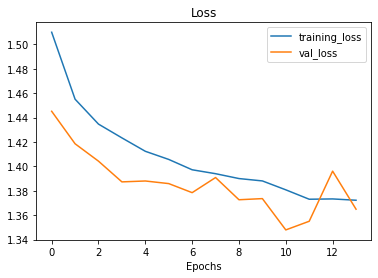

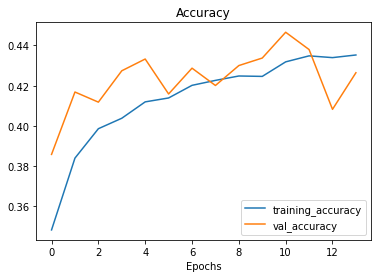

In [ ]:
plot_loss_curves(history02)

# Model Architecture

baseline model architecture

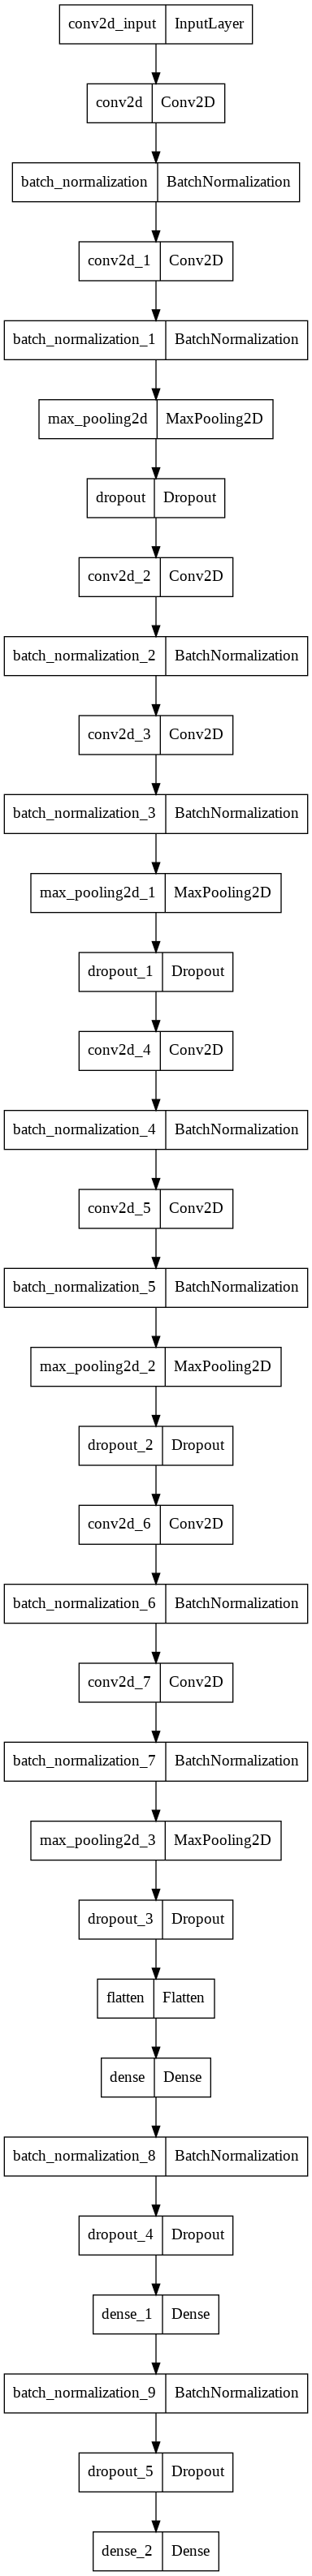

In [ ]:
plot_model(model01, to_file='model.png')

EfficientNetB0 model architecture

for related info detail [link](https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142)

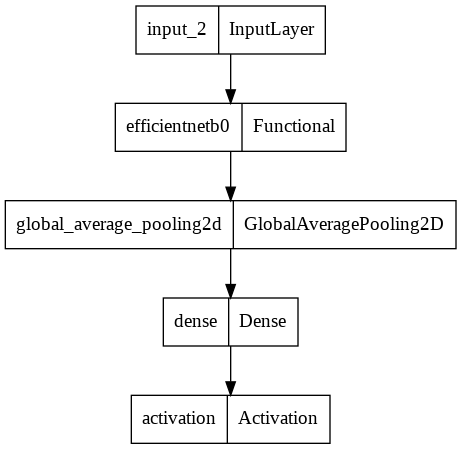

In [ ]:
plot_model(model_enb0, to_file='model.png')

# Save Model

After comparing the two models above, from the results obtained, the baseline model has better accuracy, so I will save the baseline model

In [ ]:
model_json = model01.to_json()
with open('model01.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
the_model = save_model(model01, '/content/weights_emotions.hdf5')

In [ ]:
with open('/content/model01.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "batch_input_shape": [null, 48, 48, 1], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0.001, "c

In [ ]:
model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('/content/weights_emotions.hdf5')
model_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

# Model Evaluation

In [ ]:
model_loaded.evaluate(test_dataset)

62/62 [==============================] - 3s 42ms/step - loss: 1.0582 - accuracy: 0.5755


[1.058212161064148, 0.5755115151405334]

In [ ]:
predictions = model_loaded.predict(test_dataset)
predictions

array([[0.17479089, 0.06253033, 0.4934162 , 0.06894084, 0.20032173],
       [0.45708984, 0.26980713, 0.05048122, 0.08376911, 0.13885269],
       [0.47039258, 0.07428044, 0.0142225 , 0.26397756, 0.17712699],
       ...,
       [0.07720286, 0.1305435 , 0.00788175, 0.33511722, 0.44925466],
       [0.15277016, 0.07005325, 0.06002734, 0.5033108 , 0.21383843],
       [0.25344682, 0.12427171, 0.10273968, 0.22060473, 0.29893705]],
      dtype=float32)

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([2, 0, 0, ..., 4, 3, 4])

In [ ]:
accuracy_score(test_dataset.classes, predictions)

0.5755115297174407

after evaluate the model with test dataset, the model accuracy results are 0.57

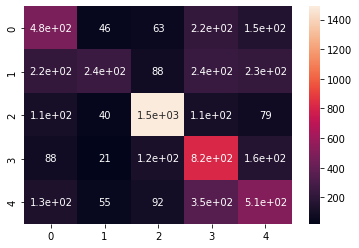

In [ ]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.47      0.50      0.48       960
           1       0.60      0.24      0.34      1018
           2       0.80      0.82      0.81      1825
           3       0.47      0.68      0.56      1216
           4       0.45      0.45      0.45      1139

    accuracy                           0.58      6158
   macro avg       0.56      0.54      0.53      6158
weighted avg       0.59      0.58      0.56      6158



In [ ]:
test_dataset.class_indices

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}

from confusion matrix above i get report for the most difficult model to predict is fear mood and the most easiest model to predict is neutral mood

# Model Inferance

i take random image from google for new dataset 

In [ ]:
!wget 'https://img.freepik.com/free-photo/bearded-guy-brown-coat-with-sad-face_1258-6716.jpg?size=626&ext=jpg'

--2022-01-11 16:13:22--  https://img.freepik.com/free-photo/bearded-guy-brown-coat-with-sad-face_1258-6716.jpg?size=626&ext=jpg
Resolving img.freepik.com (img.freepik.com)... 23.11.197.128, 2600:1407:f800:489::30ec, 2600:1407:f800:486::30ec
Connecting to img.freepik.com (img.freepik.com)|23.11.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32466 (32K) [image/jpeg]
Saving to: ‘bearded-guy-brown-coat-with-sad-face_1258-6716.jpg?size=626&ext=jpg’

bearded-guy-brown-c 100%[===================>]  31.71K  --.-KB/s    in 0.01s   

2022-01-11 16:13:22 (2.65 MB/s) - ‘bearded-guy-brown-coat-with-sad-face_1258-6716.jpg?size=626&ext=jpg’ saved [32466/32466]



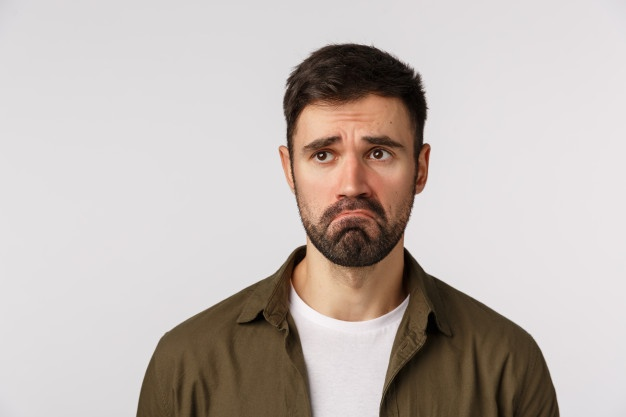

In [ ]:
image = cv2.imread('/content/bearded-guy-brown-coat-with-sad-face_1258-6716.jpg?size=626&ext=jpg')
cv2_imshow(image)

In [ ]:
image.shape

(417, 626, 3)

In [ ]:
face_detector = cv2.CascadeClassifier('/content/drive/MyDrive/Salinan haarcascade_frontalface_default.xml')
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)
faces

array([[272,  89, 163, 163]], dtype=int32)

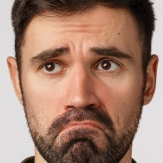

In [ ]:
roi = image[89:89 + 163, 272:272 + 163]
cv2_imshow(roi)

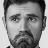

In [ ]:
roi = cv2.resize(roi, (48, 48))
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
cv2_imshow(roi)

In [ ]:
roi = roi / 255
roi

array([[0.8627451 , 0.85882353, 0.85490196, ..., 0.81960784, 0.87058824,
        0.8745098 ],
       [0.8627451 , 0.85882353, 0.87843137, ..., 0.86666667, 0.87843137,
        0.8745098 ],
       [0.8627451 , 0.85882353, 0.87058824, ..., 0.77647059, 0.87058824,
        0.87058824],
       ...,
       [0.8745098 , 0.8745098 , 0.8745098 , ..., 0.88235294, 0.88235294,
        0.88235294],
       [0.8745098 , 0.8745098 , 0.8745098 , ..., 0.88235294, 0.88235294,
        0.88235294],
       [0.87058824, 0.87058824, 0.87058824, ..., 0.87843137, 0.88235294,
        0.88235294]])

In [ ]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48)

In [ ]:
probs = model_loaded.predict(roi)
probs

array([[0.09676497, 0.599525  , 0.00614702, 0.17366962, 0.1238934 ]],
      dtype=float32)

In [ ]:
result = np.argmax(probs)
result

1

after the test, the model predict new dataset as fear mood which is right

I took another photo from google. this time the photo is showing a lot of emotion in one frame

In [ ]:
!wget 'https://miro.medium.com/max/610/1*o8avuWLJRizq04TNpmmqdQ.jpeg'

--2022-01-11 16:13:24--  https://miro.medium.com/max/610/1*o8avuWLJRizq04TNpmmqdQ.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.152.4, 162.159.153.4, 2606:4700:7::a29f:9904, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.152.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42709 (42K) [image/jpeg]
Saving to: ‘1*o8avuWLJRizq04TNpmmqdQ.jpeg’

1*o8avuWLJRizq04TNp 100%[===================>]  41.71K  --.-KB/s    in 0s      

2022-01-11 16:13:24 (121 MB/s) - ‘1*o8avuWLJRizq04TNpmmqdQ.jpeg’ saved [42709/42709]



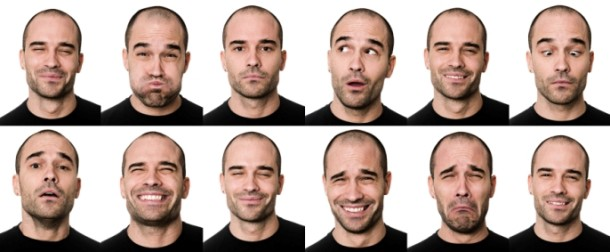

In [ ]:
image2 = cv2.imread('/content/1*o8avuWLJRizq04TNpmmqdQ.jpeg')
cv2_imshow(image2)

In [ ]:
faces = face_detector.detectMultiScale(image2)
faces

array([[216,  19,  74,  74],
       [ 17,  22,  70,  70],
       [420,  21,  72,  72],
       [523,  20,  76,  76],
       [316,  16,  83,  83],
       [118,  24,  77,  77],
       [  9, 133,  81,  81],
       [425, 145,  74,  74],
       [116, 141,  71,  71],
       [216, 145,  71,  71],
       [313, 146,  81,  81],
       [524, 148,  70,  70],
       [322, 179,  65,  65]], dtype=int32)

In [ ]:
test_dataset.class_indices.keys()

dict_keys(['angry', 'fear', 'happy', 'neutral', 'sad'])

In [ ]:
emotions = ['angry', 'fear', 'happy', 'neutral', 'sad']

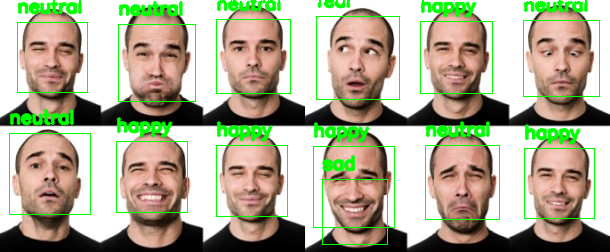

In [ ]:
for (x, y, w, h) in faces:
  cv2.rectangle(image2, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi2 = image2[y:y + h, x:x + w]
  #cv2_imshow(roi2)
  roi2 = cv2.resize(roi2, (48, 48))
  roi2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2GRAY)
  #cv2_imshow(roi2)
  roi2 = roi2 / 255
  roi2 = np.expand_dims(roi2, axis = 0)
  #print(roi2.shape)
  prediction = model_loaded.predict(roi2)
  #print(prediction)
  cv2.putText(image2, emotions[np.argmax(prediction)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
cv2_imshow(image2)

after the test, the model is predict 13 mood even though there are only 12 moods in the picture, 1 is false positive